<a href="https://colab.research.google.com/github/Advanced-Research-Centre/HilbertCorps/blob/main/Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install qiskit
!pip3 install qiskit-aer
!pip3 install matplotlib
# !pip3 install gymnasium
# !pip3 install pylatexenc

In [2]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np
import copy
%matplotlib inline
import matplotlib.pyplot as plt
simulator = Aer.get_backend('statevector_simulator')

In [36]:
k = 1         # Number of qubits of information
n = 3         # Dimension of encoding space
s = n - k     # Maximum number of syndrome measurements allowed

perr_x = 0
perr_y = 0
perr_z = 0

trials = 5    # How many random input quantum states will be tested for the QECC scheme
shots = 100  # For penalty precision

def prep_state(qc,ax,ay):
    qc.rx(ax, range(k))
    qc.ry(ay, range(k))
    qc.measure(range(k), range(k))
    return qc

def add_enc_circ(ax,ay):
    qc=QuantumCircuit(n+s, k)
    qc.rx(ax, range(k))
    qc.ry(ay, range(k))
    qc.barrier()
    for i in range(0,n-k):  # Currently works only for k = 1. For higher k, block encoding?
        qc.cx(k-1,k+i)
    qc.barrier()
    return qc

def add_err_circ(qc):
    for i in range(n):
        px = np.random.rand()
        py = np.random.rand()
        pz = np.random.rand()
        error_indices = []
        if px < perr_x:
            qc.x(i)
        if py < perr_y:
            qc.y(i)
        if pz < perr_z:
            qc.z(i)
    return qc

def add_dec_circ(qc):
    for i in range(0,n-k):  # Currently works only for k = 1. For higher k, block encoding?
        qc.cx(k-1,k+i)
    qc.barrier()
    qc.measure(range(k), range(k))
    return qc

In [74]:
def add_syn_circ():
    qc = QuantumCircuit(n+s, k)
    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(1,4)
    qc.cx(2,4)
    qc.barrier()
    qc.x(3)
    qc.mcx([3,4],0)
    qc.x(3)
    qc.x(4)
    qc.mcx([3,4],2)
    qc.x(4)
    qc.mcx([3,4],1)
    qc.barrier()
    return qc

In [75]:
def gen_syn_circ(syn_trail_list, avg_penalty_list):
    qc = QuantumCircuit(n+s, k)
    num_syndrome_gates = 4
    num_recovery_gates = 3
    # Agent's action Part 1
    for _ in range(num_syndrome_gates):
        data_qubit = np.random.randint(n)
        syndrome_qubit = np.random.randint(n, n + s)
        qc.cx(data_qubit, syndrome_qubit)
    # Agent's action Part 2
    for _ in range(num_recovery_gates):
        target_qubit = np.random.randint(n)
        num_controls = np.random.randint(1, s + 1)
        control_qubits = list(np.random.choice(np.arange(n, n + s), size=num_controls, replace=False))    # Change to inverted control
        qc.cx(control_qubits, target_qubit)
    return qc

In [62]:
def run_episode(syn_qc):
    penalties = []
    np.random.seed(1)           # Remove later, now for testing

    for trial in range(trials):

        qc = QuantumCircuit(k, k)
        ax = np.random.rand()*2*np.pi
        ay = np.random.rand()*2*np.pi

        q_state = prep_state(qc, ax, ay)

        result = execute(q_state, simulator, shots=shots).result()
        m1 = result.get_counts(q_state)

        ec = add_enc_circ(ax, ay)

        err_trials = 10       # How many times a specific choice of syndrome circuit is tested for different random errors, bigger the better (and slower)

        for _ in range(err_trials):

            enc_circ = copy.deepcopy(ec)

            err_circ = add_err_circ(enc_circ)

            syn_circ = err_circ.compose(syn_qc)

            dec_circ = add_dec_circ(syn_circ)

            result = execute(dec_circ, simulator, shots=shots).result()
            m2 = result.get_counts(dec_circ)

            penalty = sum(abs(m1.get(key, 0) - m2.get(key, 0))/shots for key in set(m1) | set(m2))  # This is the agent's penalty

            penalties.append(penalty)

    return penalties  #, best_penalty, best_syndrome_circuit

                          ░      ┌───┐                     ░ 
q_0: ──■──────────────────░──────┤ X ├─────────────────────░─
       │                  ░      └─┬─┘               ┌───┐ ░ 
q_1: ──┼────■────■────────░────────┼─────────────────┤ X ├─░─
       │    │    │        ░        │       ┌───┐     └─┬─┘ ░ 
q_2: ──┼────┼────┼────■───░────────┼───────┤ X ├───────┼───░─
     ┌─┴─┐┌─┴─┐  │    │   ░ ┌───┐  │  ┌───┐└─┬─┘       │   ░ 
q_3: ┤ X ├┤ X ├──┼────┼───░─┤ X ├──■──┤ X ├──■─────────■───░─
     └───┘└───┘┌─┴─┐┌─┴─┐ ░ └───┘  │  ├───┤  │  ┌───┐  │   ░ 
q_4: ──────────┤ X ├┤ X ├─░────────■──┤ X ├──■──┤ X ├──■───░─
               └───┘└───┘ ░           └───┘     └───┘      ░ 
c: 1/════════════════════════════════════════════════════════
                                                             


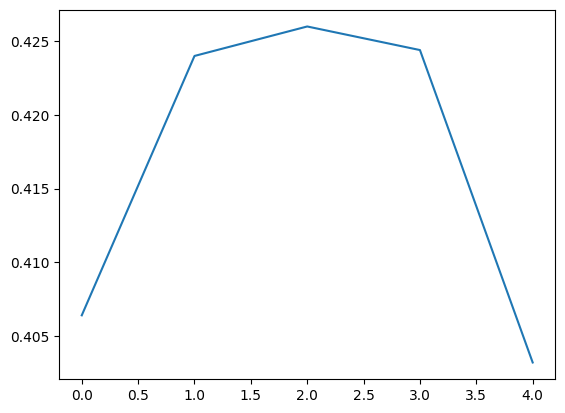

In [72]:
from numpy.ma.extras import average
from statistics import mean

perr_x = 0.4
perr_y = 0
perr_z = 0

syn_trails = 5
best_avg_penalty = float('inf')
best_syndrome_circuit = None
avg_penalty_list = []
syn_trail_list = []

for t in range(syn_trails):
    # syn_circ = gen_syn_circ(syn_trail_list,avg_penalty_list)               # Action of the agent (Random)
    syn_circ = add_syn_circ()
    syn_trail_list.append(syn_circ)
    penalties = run_episode(syn_circ)       # Interaction with the environment, performs the action on the environment
    avg_penalty = np.mean(penalties)        # Penalty
    # print(t, avg_penalty)
    avg_penalty_list.append(avg_penalty)
    if avg_penalty < best_avg_penalty:
        best_avg_penalty = avg_penalty
        best_syndrome_circuit = copy.deepcopy(syn_circ)

plt.plot(avg_penalty_list)
print(best_syndrome_circuit)

[0.008, 0.0048, 0.0088, 0.0134, 0.017, 0.001, 0.0182, 0.0024, 0.0216, 0.0124, 0.0016, 0.004, 0.008, 0.02, 0.0036, 0.0078, 0.0036, 0.0056, 0.0204, 0.0068]
[0.3164, 0.0106, 0.01, 0.0084, 0.0308, 0.0278, 0.0154, 0.0306, 0.0002, 0.0128, 0.0006, 0.018, 0.008, 0.0064, 0.003, 0.0692, 0.0248, 0.0044, 0.0154, 0.0226]
[0.3248, 0.011, 0.007, 0.0108, 0.004, 0.015, 0.005, 0.0148, 0.0026, 0.0, 0.0058, 0.0042, 0.003, 0.0078, 0.0114, 0.051, 0.5628, 0.02, 0.01, 0.528]


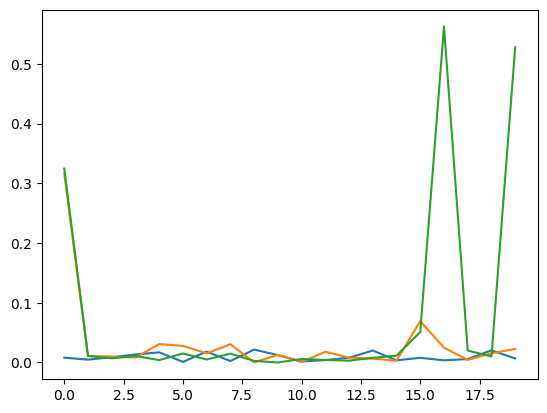

In [ ]:
perr_x = 0
perr_y = 0
perr_z = 0
penalties_0, best_penalty, best_syndrome_circuit = run_episode()
print(penalties_0)
# print("Best Penalty:",best_penalty)
# print("Best Syndrome Circuit:",best_syndrome_circuit)

perr_x = 0.2
perr_y = 0
perr_z = 0
penalties_1, best_penalty, best_syndrome_circuit = run_episode()
print(penalties_1)

perr_x = 0.4
perr_y = 0
perr_z = 0
penalties_2, best_penalty, best_syndrome_circuit = run_episode()
print(penalties_2)

plt.plot(penalties_0)
plt.plot(penalties_1)
plt.plot(penalties_2)